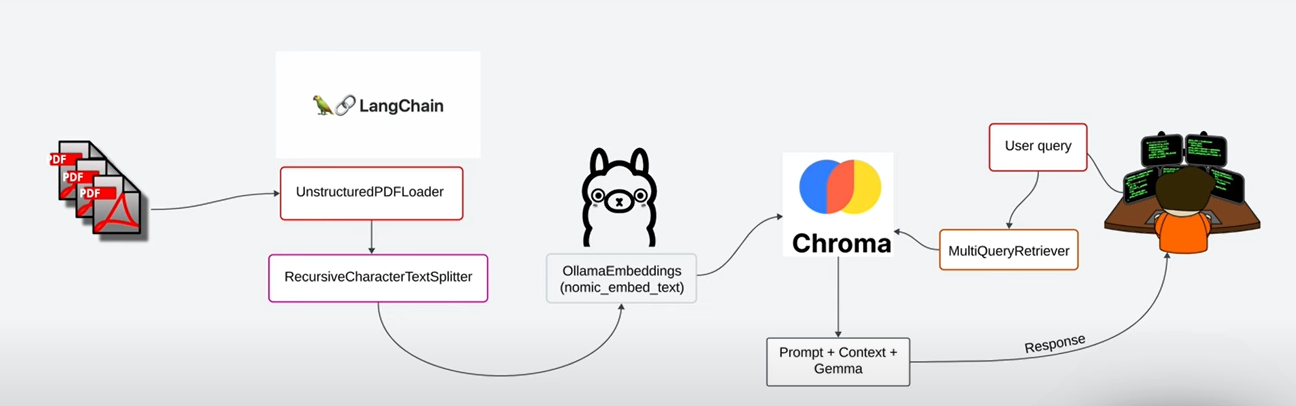

In [1]:
%pip install --q unstructured langchain
%pip install --q "unstructured[all-docs]"

Note: you may need to restart the kernel to use updated packages.


ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 27526a84cebc4c4d53fea9d1ebbc7209c8d279bebaa343e6765a1fc8780565ab
             Got        43f5ff0490d1650c2d3f7e1a21a4633a13f971b849f8b266fe41e582e59d7811



Note: you may need to restart the kernel to use updated packages.


DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Loading PDFs

In [1]:
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.document_loaders import OnlinePDFLoader

In [2]:
import os
pdf_path = 'pdf files/DeepLearning.pdf'
if not os.path.exists(pdf_path):
    print('The PDF file does not exist. Please upload the PDF file to the path: pdf files/DeepLearning.pdf')
else:
    pdf_loader = UnstructuredPDFLoader(pdf_path)
    data = pdf_loader.load()

### Vector Embeddings

In [32]:
%pip install --q chromadb
%pip install --q langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

In [4]:
splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=100)
texts = splitter.split_documents(data)

In [5]:
!ollama pull nomic-embed-text

pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 M

In [6]:
!ollama list

NAME                   	ID          	SIZE  	MODIFIED      
nomic-embed-text:latest	0a109f422b47	274 MB	9 seconds ago	


In [7]:
vector_databse = Chroma.from_documents(
    documents = texts,
    embedding=OllamaEmbeddings(model="nomic-embed-text",show_progress=True),
    collection_name="local-rag"
)

OllamaEmbeddings: 100%|██████████| 205/205 [52:34<00:00, 15.39s/it]


## Data Retrieval

In [8]:
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.multi_query import MultiQueryRetriever

In [10]:
model_name = 'mistral'
chat_model = ChatOllama(model=model_name)

In [11]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from
    a vector database. By generating multiple perspectives on the user question, your
    goal is to help the user overcome some of the limitations of the distance-based
    similarity search. Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

In [12]:
retriever = MultiQueryRetriever.from_llm(
    vector_databse.as_retriever(),
    chat_model,
    QUERY_PROMPT,
)

Rag_Template = """Answer the question based ONLY on the following context:
{context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(Rag_Template)

In [13]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | chat_model
    | StrOutputParser()
)

In [18]:
chain.invoke(input(""))

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]
